In [2]:
import matplotlib.pyplot as plt
from matplotlib. patches import Polygon
import numpy as np
from math import pi
from IPython.display import display


In [41]:
class Figure:
    coords = np.array([])

    def __init__(self, x, y, *side):
        if len(side) > 1:
            a = np.array([x, y])
            b = np.array(side[:2])
            # b справа
            if x > b[0]:
                a, b = b, a
            if x == b[0] and y > b[1]:
                a, b = b, a
            v = b-a
            self.side = sum(v**2)**0.5
            if v[0] == 0:
                angle = 90
            else:
                angle = np.math.atan(v[1]/v[0])*180/pi
            if side[2] == 0:
                self.set_coords(*a, self.side)
                self.rotate(angle, *a)
            else:
                self.set_coords(*b, self.side)
                self.rotate(angle-180, *b)
        else:
            self.side = side[0]
            self.set_coords(x, y, self.side)
        self.d2c = self.distance2center()

    def S(self):
        return self.P()/2 * sum((self.coords[:2].mean(0) - self.center())**2)**0.5
    
    def P(self):
        return self.side * len(self.coords)
    
    def set_coords(self):
        ...

    def draw(self, ax, color='cyan'):
        poly = Polygon(self.coords, fill=True, closed=True, color=color)
        ax.add_patch(poly)

    def rotate(self, angle, x=0, y=0):
        mat = np.array([
            [np.math.cos(angle*pi/180), -np.math.sin(angle*pi/180)],
            [np.math.sin(angle*pi/180), np.math.cos(angle*pi/180)]
        ])
        for n, cors in enumerate(self.coords):
            self.coords[n] = (mat @ (cors - [x, y])) + [x, y]

    def mirror(self, x=False, y=False):
        if x:
            self.coords[:, 0] *= -1
        if y:
            self.coords[:, 1] *= -1
    
    def move(self, x, y):
        self.coords[:, 0] += x
        self.coords[:, 1] += y
    def gom(self, delta):
        self.coords = self.coords / delta
    
    def dif(self, x, y):
        cors = self.coords
        center = self.center()
        # True если точка внутри фигуры
        #! Находим расстояния до всех вершин фигуры
        l = ((cors - [x, y])**2).sum(axis=1)**0.5
        #! Сортируем точки по возрастанию расстояния
        c = cors[np.argsort(l)]
        #! Находим ближайший вектор
        v = c[1] - c[0]
        #! Проецируем точку на отрезок по Y
        if v[0] != 0:
            dot_shift = (x-c[0, 0])*v[1]/v[0]+c[0, 1] - y
            center_shift = (center[0]-c[0, 0])*v[1]/v[0]+c[0, 1] - center[1]
        else:
            dot_shift = x*v[0]/v[1]+c[0, 0] - x
            center_shift = center[1]*v[0]/v[1]+c[0, 0] - center[0]
        #! Определяем одинаковый ли по знаку сдвиг
        # ? 0 - сдвига небыло
        return dot_shift * center_shift > 0
    
    def center(self):
        return self.coords.mean(0)
    
    def distance2center(self):
        loc_center = self.coords[0] + (self.coords[1] - self.coords[0])/2
        return sum((loc_center - self.center())**2)**0.5

    def is_cross(self, fi, first=True):
        # Проверяем лежит ли хоть одна из наших точек в другой фигуре
        for x, y in self.coords:
            if fi.dif(x, y):
                return True
        if fi.dif(*self.center()):
            return True
        
        if first:
            return fi.is_cross(self, False)
        
        c2c = sum((self.center() - fi.center())**2)**0.5
        
        return c2c < self.d2c + fi.d2c
        


In [43]:

class Triangle(Figure):
    def set_coords(self, x, y, side):
        self.coords = np.array([
            [x, y],
            [x+side, y],
            [x+side/2, y+side*3**0.5/2],
        ])


In [44]:
class Squre(Figure):
    def set_coords(self, x, y, side):
        self.coords = np.array([
            [x, y],
            [x, y+side],
            [x+side, y+side],
            [x+side, y],
        ])

In [45]:
class Hexagon(Figure):
    def set_coords(self, x, y, side):
        
        h = side*3**0.5/2
        self.coords = np.array([
            [x, y],
            [x+side, y],
            [x+side*1.5, y+h],
            [x+side, y+h*2],
            [x, y+h*2],
            [x-side/2, y+h],
        ])


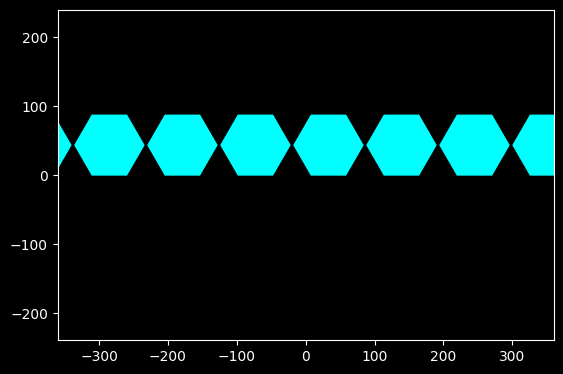

In [29]:

class Figures:

    figs = []

    def __init__(self, fig=Squre, count=3, side=50, width=720, height=480):
        self.side = side
        self.space = side//10

        self.width, self.height = width, height
        self.fig, self.ax = plt.subplots()
        self.ax.set_xlim([-width//2, width//2])
        self.ax.set_ylim([-height//2, height//2])
        self.ax.set_aspect(1)
        x = fig(0, 0, side).coords[:, 0]
        self.fig_width = max(x) - min(x)
        self._generate(count, fig)
        self._draw()

    def _generate(self, count=None, fig=Squre):

        if count is None:
            count = int((self.width**2 + self.height**2)**0.5//self.fig_width+2)
        start = int(-((self.fig_width+self.space)*count-self.space)/2)
        for i in range(count):
            self.figs.append(
                fig(start+(self.fig_width+self.space+1)*i, 0, self.side))

    def _draw(self):
        self.ax.cla()
        self.ax.set_xlim([-self.width//2, self.width//2])
        self.ax.set_ylim([-self.height//2, self.height//2])
        for fig in self.figs:
            fig.draw(self.ax)
    
    def move(self, x=0, y=0):
        for fig in self.figs:
            fig.move(x, y)
        self._draw()

    def rotate(self, angele):
        for fig in self.figs:
            fig.rotate(angele)
        self._draw()
    
    def gom(self, delta):
        for fig in self.figs:
            fig.gom(delta)
        self._draw()

    def mirror(self, x=False, y=False):
        for fig in self.figs:
            fig.mirror(x, y)
        self._draw()

fig = Figures(Hexagon, None)
# fig.rotate(60)
# fig.move(0, 70)
# fig.gom(1.2)
# fig.mirror(x=True, y=True)

Площадь = 371147.36709748715
Периметр = 6600


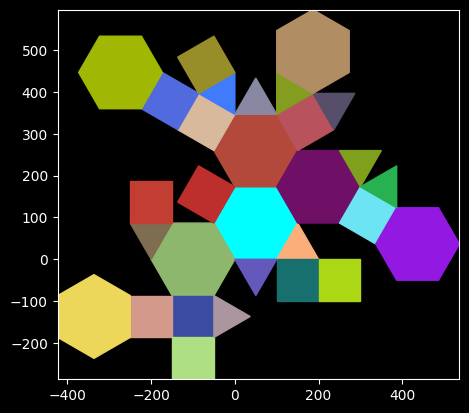

In [64]:
mmas = [Triangle, Triangle, Triangle]
col = ['cyan', 'cyan', 'red']
seed(1223)
np.random.seed(123)


def franc(count, width=192*5, height=108*5):
    figs = (Squre, Triangle, Hexagon)
    canvas, ax = plt.subplots()
    ax.set_aspect(1)
    dots = []
    fig = choice(figs)(0, 0, 100)
    fig.draw(ax)
    dots.append(fig)
    for i in range(count-1):
        fig_cls = choice(figs)
        # Нам нужны всевозможные ребра
        for last_figure in dots:
            l = len(last_figure.coords)
            r = randint(0, l)
            for n in range(l):
                for t in (0, 1):
                    d1 = last_figure.coords[(n+r) % l]
                    d2 = last_figure.coords[(n+r+1) % l]
                    fig = fig_cls(*d1, *d2, t)

                    for old_fig in dots:
                        if fig.is_cross(old_fig):
                            break
                    else:
                        break
                else:
                    continue
                break
            else:
                continue
            break
        fig.draw(ax, color=np.random.random(3))
        dots.append(fig)

    cors = np.vstack([fi.coords for fi in dots])
    ax.set_xlim([min(cors[:, 0]), max(cors[:, 0])])
    ax.set_ylim([min(cors[:, 1]), max(cors[:, 1])])
    s = sum(f.S() for f in dots)
    lines = []
    for fig in dots:
        l = len(fig.coords)
        for cor in range(l):
            d1 = tuple(map(lambda x: round(x, 3), fig.coords[cor]))
            d2 = tuple(map(lambda x: round(x, 3), fig.coords[(cor+1) % l]))
            line = tuple(sorted([d1, d2]))
            lines.append(line)
    p = len(list(filter(lambda x: lines.count(x) == 1, lines))) * dots[0].side
    print('Площадь =', s)
    print('Периметр =', p)
    


franc(30)


In [8]:
from os import name
from typing import Any


class Vectors:

    def __init__(self) -> None:
        self.fig, self.ax = plt.subplots()
        self.ax.set_aspect(1)
    

    def __setattr__(self, __name: str, __value: Any) -> None:
        if __name.isupper() and len(__name) == 1:
            super().__setattr__(__name, np.array(__value))
            self.ax.plot(*__value, '.')
        else:
            super().__setattr__(__name, __value)

    def __getattribute__(self, __name: str) -> Any:
        if __name.isupper() and len(__name) == 2:
            A = self.__getattribute__(__name[0])
            B = self.__getattribute__(__name[1])
            self.ax.plot(*zip(A, B), )
            return B-A
        else:
            return super().__getattribute__(__name)


array([-0.1339746 ,  2.23205081])

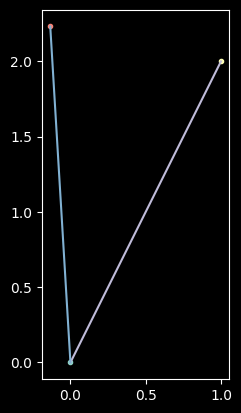

In [9]:

v = Vectors()
v.A = (0, 0)
v.B = (1, 2)

mat = np.array([
    [np.math.cos(30*pi/180), -np.math.sin(30*pi/180)],
    [np.math.sin(30*pi/180), np.math.cos(30*pi/180)]
])

v.C = mat @ v.AB
v.AC

In [10]:
def choice(*d):
    return mmas.pop()

In [11]:
from random import choice, seed, randint

In [12]:
from icecream import ic

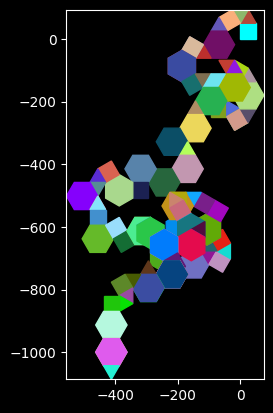

In [34]:
mmas = [Triangle, Triangle, Triangle]
col = ['cyan', 'cyan', 'red']
seed(123)
np.random.seed(123)
def franc(count, width=192*5, height=108*5):
    figs = (Squre, Triangle, Hexagon)
    canvas, ax = plt.subplots()
    ax.set_aspect(1)
    dots = []
    fig = choice(figs)(0, 0, 50)
    fig.draw(ax)
    dots.append(fig)
    flag = False
    for i in range(count-1):
        fig_cls = choice(figs)
        l = len(dots[-1].coords)
        r = randint(0, l)
        for n in range(l):
            for t in (0, 1):
                d1 = dots[-1].coords[(n+r) % l]
                d2 = dots[-1].coords[(n+r+1) % l]
                fig = fig_cls(*d1, *d2, t)
                
                for old_fig in dots:
                    flag = fig.is_cross(old_fig)
                    

                    if flag:
                        break
                if not flag or t:
                    break
                flag = False
            if not flag:
                break
            flag = False
        fig.draw(ax, color=np.random.random(3))
        dots.append(fig)
    cors = np.vstack([fi.coords for fi in dots])
    ax.set_xlim([min(cors[:, 0]), max(cors[:, 0])])
    ax.set_ylim([min(cors[:, 1]), max(cors[:, 1])])
        
#! Основная проблема - свернувшись в улиточку мы уже не можем равзверунться
franc(100)

In [15]:
figure = Triangle(0, 0, 10, 10, 0, color='red')

fig, ax = plt.subplots()
x, y = figure.coords.T
margin = 10
ax.set_xlim([min(x)-margin, max(x)+margin])
ax.set_ylim([min(y)-margin, max(y)+margin])
ax.set_aspect(1)
figure.draw(ax)

center = figure.coords.sum(0)/figure.coords.shape[0]
ax.plot(*center, 'ok')

TypeError: Figure.__init__() got an unexpected keyword argument 'color'

In [ ]:
np.random.random(3)


array([0.55131477, 0.71946897, 0.42310646])

array([[436.        , 295.        ],
       [411.        , 338.        ],
       [386.26090764, 294.84936491]])

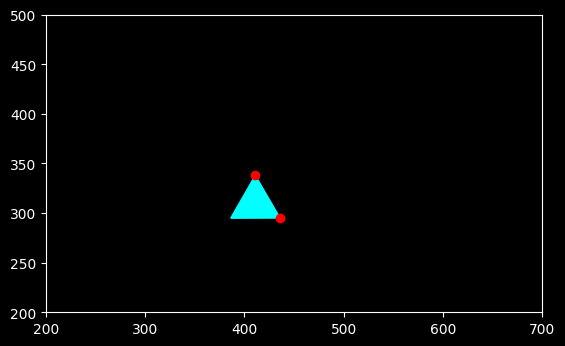

In [ ]:
f, a = plt.subplots()
a.set_xlim([200, 700])
a.set_ylim([200, 500])
a.set_aspect(1)
d1 = 436, 295
d2 = 411, 338
t = Triangle(*d1, *d2, 1)
t.draw(a)
a.plot(*d1, 'or')
a.plot(*d2, 'or')
t.coords

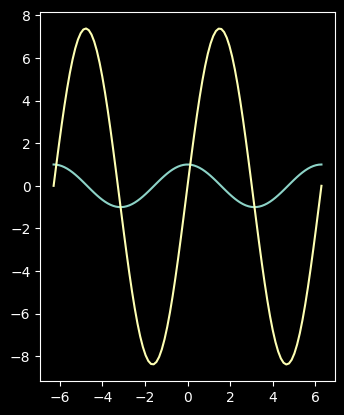

In [ ]:
X = np.linspace(-2*pi, 2*pi, 100)
Y1 = []
Y2 = [0]
fl = True
for i in X:
    Y1.append(np.math.cos(i))
    if fl:
        fl = False
    else:
        Y2.append(Y1[-1] + Y2[-1])
f, a = plt.subplots()
a.set_aspect('equal')
a.plot(X, Y1, X, Y2)

In [ ]:
figure = Triangle(0, 0, 10, 10, 0, color='red')

fig, ax = plt.subplots()
x, y = figure.coords.T
margin = 10
ax.set_xlim([min(x)-margin, max(x)+margin])
ax.set_ylim([min(y)-margin, max(y)+margin])
ax.set_aspect(1)
figure.draw(ax)

center = figure.coords.sum(0)/figure.coords.shape[0]
ax.plot(*center, 'ok')

TypeError: Figure.__init__() got an unexpected keyword argument 'color'

True

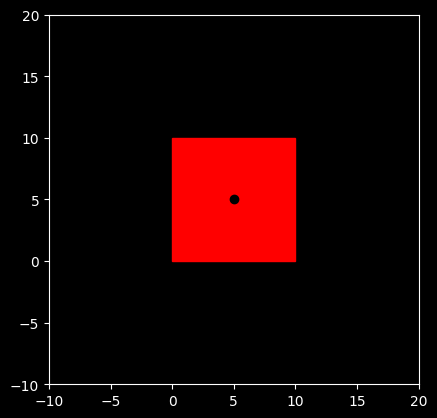

In [ ]:
figure = Squre(0, 0, 10, color='red')

fig, ax = plt.subplots()
x, y = figure.coords.T
margin = 10
ax.set_xlim([min(x)-margin, max(x)+margin])
ax.set_ylim([min(y)-margin, max(y)+margin])
ax.set_aspect(1)
figure.draw(ax)

side = (2+2**0.5)*10
center = figure.coords.sum(0)/figure.coords.shape[0]
ax.plot(*center, 'ok')
cors = figure.coords
test(5, 5, center, cors)


In [ ]:
def test(x, y, center, cors):
    # True если точка внутри фигуры
    #! Находим расстояния до всех вершин фигуры
    l = ((cors - [x, y])**2).sum(axis=1)**0.5
    #! Сортируем точки по возрастанию расстояния
    c = cors[np.argsort(l)]
    #! Находим ближайший вектор
    v = c[1] - c[0]
    #! Проецируем точку на отрезок по Y
    if v[0] != 0:
        dot_shift = (x-c[0, 0])*v[1]/v[0]+c[0, 1] - y
        center_shift = (center[0]-c[0, 0])*v[1]/v[0]+c[0, 1] - center[1]
    else:
        dot_shift = x*v[0]/v[1]+c[0, 0] - x
        center_shift = center[1]*v[0]/v[1]+c[0, 0] - center[0]
    #! Определяем одинаковый ли по знаку сдвиг
    #? 0 - сдвига небыло
    return dot_shift * center_shift > 0


test(14, 0, center, cors)


False

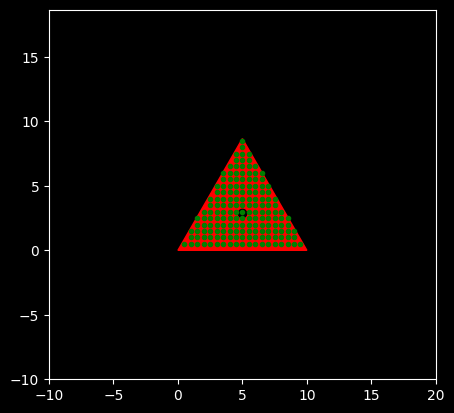

In [ ]:

for x in np.arange(-5, 20, 0.5):
    for y in np.arange(-5, 20, 0.5):
        if test(x, y, center, cors):
            ax.plot(x, y, '.g')

display(fig)